In [1]:
# imports
import os
import shutil

import numpy as np
import pandas as pd
from skimage.morphology import skeletonize
from PIL import Image
import cv2
import re
import glob
import random

from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, Checkpoint, EpochScoring, EarlyStopping
from skorch.dataset import Dataset
from skorch.helper import predefined_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from pathlib import Path
import tensorflow as tf
from tensorflow import keras
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from sklearn import metrics
from tqdm import tqdm

In [2]:
from utils_train import channeled_image_from_id, process_skeletonize, substitute_channels

In [10]:
def average_pixel_count_random_images2(img_channel, median_number_of_pixels, # all images 224 x 224
                    image_size = (224, 224)):
    
    # random selection of removal/add means that relatively proportionate amount / pixel intensity is being added
    # since PIV values more present have higher chance of being selected
    
    print("------------------")
    channel_flatten = np.copy(np.array(img_channel.flatten()))
    
    assert (len(channel_flatten) == 224 * 224)
    
    num_nonzero_img = np.count_nonzero(img_channel) # num pixels in 1 channel
    pixels_to_modify = num_nonzero_img - median_number_of_pixels
    
    # array of nonzero and zero id locations
    
    nonzero_pixels = []
    zero_pixels = []
    
    for i in range(0, len(channel_flatten)):
        if channel_flatten[i] == 0:
            zero_pixels.append(i) # index value
        elif channel_flatten[i] != 0:
            nonzero_pixels.append(i)
    
    zero_pixels = np.array(zero_pixels)
    nonzero_pixels = np.array(nonzero_pixels)
                    
    assert(len(nonzero_pixels) + len(zero_pixels) == len(channel_flatten))
    
    modified_channel_flatten = np.copy(channel_flatten)
    print(pixels_to_modify)
    
    if pixels_to_modify > 0: # remove pixels
        print('remove pixels')
        num_pixels_remove = pixels_to_modify # should be positive
        indexes = np.random.choice(len(nonzero_pixels), num_pixels_remove, replace=False)
        remove_pixel_indexes = nonzero_pixels[indexes]
        modified_channel_flatten[remove_pixel_indexes] = 0
    
    elif pixels_to_modify <= 0: # add pixels
        print('add pixels')
        # ok, for randomization. We'll have the image. 
        # We'll randomly choose a nonzero pixel and then duplicate it, storing that in another image (in a random location that is zero)
        # Then continue choosing from the image. 
        # Should randomly even out because selection of nonzero pixels to duplicate should be proportional
        
        num_pixels_add = abs(pixels_to_modify)
        nonzero_indexes = np.random.choice(len(nonzero_pixels), num_pixels_add, replace=False)
        zero_indexes = np.random.choice(len(zero_pixels), num_pixels_add, replace=False)
        
        substituted_pixel_indexes = nonzero_pixels[nonzero_indexes]
        zero_pixel_indexes = zero_pixels[zero_indexes]
        
        modified_channel_flatten[zero_pixel_indexes] = channel_flatten[substituted_pixel_indexes]
    
    reshapen_img = modified_channel_flatten.reshape(image_size)
    
    return reshapen_img    

In [11]:
def randomly_distribute(img, skeleton, average_nonzero_pixels, median_number_of_pixels, brighten_sum, # can try with multiple brighten_sums
                       none_thresh = 0, image_size = (224, 224)): # getting rid of the complete black
    
    # for number of pixels we use non_skeletonized full_set + train/test/val sets.
    
    # sticking with none_thresh = 0 for now, brightening everything except the background. 
    # could try some thresholding on which pixels we brighten, or thresholding by zeroing some pixels.
    
    # resize/skeletonize first, and then random distribution  
    img, _ , modified_img = process_skeletonize(img, skeleton, image_size) # image size given
    
    # random distribution now 
    flattened_img = modified_img.flatten()
    random_img = np.random.permutation(flattened_img)
    modified_img2 = np.reshape(random_img, image_size)
    
    # averaging nonzero pixels
    if average_nonzero_pixels:
        print(np.count_nonzero(modified_img2))
        value_dict = pd.value_counts(modified_img2.flatten())
        
        modified_img3 = average_pixel_count_random_images2(modified_img2, median_number_of_pixels)
        
        value_dict_modified = pd.value_counts(modified_img3.flatten())
  
    elif not average_nonzero_pixels:
        modified_img3 = modified_img2
        
    # now for brightening code, will be brightening ALL pixels above 0/20? (above 0, brightening everything)
    
    # modified_img4 = apply_threshold(modified_img3, 'add', none_thresh, brighten_sum, thresh_type = 'below') # yay default
      
#     final_img = substitute_channels(img, modified_img3)

    return modified_img3, value_dict, value_dict_modified

In [12]:
dataset_path = "/users/riya/race/dataset/segmentations/"
img_path = "30672.bmp"

channels = channeled_image_from_id(dataset_path, img_path, (480, 640))

In [17]:
final_img, value_dict, value_dict_modified = randomly_distribute(channels, False, True, 15000, 0)

13954
------------------
-1046
add pixels


In [14]:
np.count_nonzero(final_img)

12000

In [15]:
value_dict

0      36222
1       4206
2       1607
3       1019
4        677
       ...  
231        2
111        2
238        1
237        1
164        1
Length: 233, dtype: int64

In [16]:
value_dict_modified

0      38176
1       3592
2       1407
3        878
4        576
       ...  
210        2
207        2
220        2
238        1
111        1
Length: 231, dtype: int64

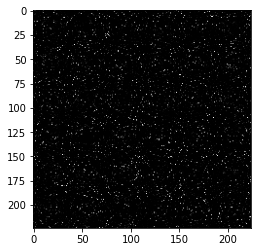

In [38]:
plt.imshow(final_img, cmap = 'gray')

In [47]:
value_dict

{}

In [ ]:
def visualize_random_images(img_id, brighten_sums, median_number_of_pixels, skeleton, average_nonzero_pixels): 
    
    num_images = len(brighten_sums)
    
    img = np.array(Image.open(f"/users/riya/race/dataset/segmentations/{img_id}.bmp"))
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2).reshape((480,640,3))
        
    for i in range(num_images):
        visualize_image = randomly_distribute(img, skeleton, average_nonzero_pixels, median_number_of_pixels, brighten_sums[i])
        
        # bad code here
        print('brightened by, ',brighten_sums[i])
        plt.imshow(visualize_image, interpolation = 'nearest')
        plt.gcf().set_size_inches(8,8)
        plt.show()

In [ ]:
number_of_pixels = 11170 # median is 11170.5

brighten_sums_arr = [0, 20, 40, 60, 80, 100, 120]
visualize_random_images(18168, brighten_sums_arr, number_of_pixels, False, True)